In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import csv

from scipy.misc     import imsave
from keras          import metrics
from PIL            import Image

import tensorflow as tf
import keras
from keras import layers
from keras.models                      import Model, load_model, Sequential
from keras.applications.vgg16          import VGG16
from keras.applications.vgg16          import decode_predictions
from keras.utils.np_utils              import to_categorical

import keras.backend     as K
import numpy             as np
import matplotlib.pyplot as plt

from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod


Using TensorFlow backend.


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
def limit_mem():
    cfg                          = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config = cfg))

In [4]:
limit_mem()

In [24]:
def create_title(category):
    return '"%s"' % (category) 

In [25]:
def generate_title(model, array):
    prediction = model.predict(array).argmax()
    category = labels[prediction]
    return create_title(category)

# Loading prerequired variables

## Clean file

In [7]:
filename = '../../Images/stop3.jpg'

(1, 100, 100, 3)


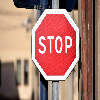

In [27]:
original_pic   = Image.open(filename).resize((100, 100))
original_array = np.expand_dims(np.array(original_pic), 0)
print(original_array.shape)
original_pic

## Labels

In [8]:
def readTrafficSigns(file_path):
    labels = [] # corresponding labels
    if os.path.isfile(file_path):
        with open(file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',') # csv parser for annotations file 
            # loop over all images in current annotations file
            for row in csv_reader:
                labels.append(row[1]) # the second column is the label
            csv_file.close()
    return labels[1:]

In [28]:
labels = readTrafficSigns("../../VGG16/signnames.csv")

# Goal

The goal of this notebook is to implement the "fast gradient sign method" presented in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572). This method is used to modify classical samples that a deep neural network trained classification will fail to classify properly.

![fgsm idea](http://karpathy.github.io/assets/break/breakconv.png "Fast Gradient Sign Method")

The idea of this method is to take a sample, ask the network to classify it, compute the gradient of the loss in function of the input pixels and update the picture by a small amount in the direction of the gradient. This direction is opposite to the one that would increase the score for the correct class.

We transform the image according to the VGG16 requirements. It consists in substracting the mean value for each channel and reversing the order of the channels. 

In [19]:
imagenet_mean      = np.array([123.68, 116.779, 103.939], dtype = np.float32)
preprocess         = lambda x: (x - imagenet_mean)
deprocess          = lambda x: (x + imagenet_mean)
preprocessed_array = preprocess(original_array)

# VGG loading

## Loading Fine-tuned VGG16 model

In [12]:
model = load_model('../../Models/VGG16/model_pur_transfer_GTSRB.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 256)               1179904   
_________________________________________________________________
Dropout_Dense_1 (Dropout)    (None, 256)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
Dropout_Dense_2 (Dropout)    (None, 512)               0         
_________________________________________________________________
Softmax (Dense)              (None, 43)                22059     
Total para

### Plotting the model

In [13]:
#from keras.utils.vis_utils import plot_model
# plot_model(model,to_file='model_plot.png', show_layer_names=True)

Now let's ask the network what he sees in the picture. 

In [14]:
pred = model.predict(preprocessed_array).argmax()
print("Predicted label : %s" %(labels[pred]))

Predicted label : Stop


# Adversarial example generation

Now we try to confuse the network by modifying the stop roadsign picture. We generate the adversarial sample using `Cleverhan` library.

In [17]:
#fgsm_params = {
  #    'eps': 0.3,
  #    'y': 14,
  #    'y_target': 10,
  #   'clip_min': 0.,
  #   'clip_max': 1.
  #}

fgsm_params = {
      'eps': 0.3,
      'clip_min': 0.,
      'clip_max': 1.
  }

# Initialize the Fast Gradient Sign Method (FGSM) attack object
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap)

# Converting the preprocessed array to a tensor for the fgsm.generate() function
tensor_preprocessed_array = tf.convert_to_tensor(preprocessed_array,dtype=np.float32)

#Generating the adversarial sample using Cleverhans library
adv_clever = fgsm.generate(tensor_preprocessed_array, **fgsm_params)
# Converting the tensor back to a np array
np_adv_clever = K.eval(K.variable(adv_clever))
pred_adv_clever = model.predict(np_adv_clever).argmax()

#Adding the perturbation to the image and deprocessing it
modified_array  = preprocessed_array + np_adv_clever
deprocessed_array = np.clip(deprocess(modified_array), 0., 255.).astype(np.uint8)

AttributeError: Layer vgg16 has multiple inbound nodes, hence the notion of "layer output" is ill-defined. Use `get_output_at(node_index)` instead.

In [ ]:
title_original     = create_title(labels[pred])
title_perturbation = create_title("Perturbation")
title_modified     = create_title(labels[pred_adv_clever])

plt.figure(figsize = (17, 17))
plt.subplot(1, 3, 1)
plt.imshow(original_array[0])
plt.title(title_original)
plt.subplot(1, 3, 2)
plt.imshow(np_adv_clever[0])
plt.title(title_perturbation)
plt.subplot(1, 3, 3)
plt.imshow(deprocessed_array[0])
plt.title(title_modified)